# DIRECT FEEDBACK ALIGNMENT

In this notebook a linear neural net with one hidden layer learns to multiply by a matrix using [direct feedback alignment](https://arxiv.org/pdf/1609.01596.pdf) instead of backpropagation.

In practice, it learns $ W_1 $, $W_2$ such that

$$ M = W_2 W_1 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)

In [2]:
def create_dataset(n_in, n_out, len_samples):
    '''Creates randomly a matrix n_out x n_in which will be
       the target function to learn. Then generates
       len_samples examples which will be the training set'''
    M = np.random.randint(low=-10, high=10, size=(n_out, n_in))
    samples = []
    targets = []    
    for i in xrange(len_samples):
        sample = np.random.randn(n_in)
        samples.append(sample)
        targets.append(np.dot(M, sample))
        
    return M, np.asarray(samples), np.asarray(targets)

The forward pass is just

$$ \hat{y} = W_2 W_1 x$$

The backward pass for DFA takes the error $e = \hat{y}-y_{true}$ and projects it onto the dimension of the hidden layer:

$$\delta W_1 = -(B_1 e)x^T$$
$$\delta W_2 = -e a_1^T$$

where $a_1 = W_1 x$.

In [3]:
# Here lies all the logic of the network
def forward_pass(input, W1, W2):
    a1 = np.dot(W1, input)
    y_hat = np.dot(W2, a1)
    return a1, y_hat
    
def backward_pass(e, B1, input, a1):
    dW1 = -(np.dot(np.dot(B1, e), np.transpose(input)))
    dW2 = -np.dot(e, np.transpose(a1))
    
    return dW1, dW2

## WHAT ALIGNS WITH WHAT?

Theorem 1 in the paper states that the negative update directions $\delta h_i$ will try to maximize an alignment criterion which, in the case of two hidden layers, is:

$$L = L_k + L_{k+1} = \frac{\delta h_k^T c_k}{||\delta h_k||} + \frac{\delta h_{k+1}^T c_{k+1}}{||\delta h_{k+1}||}$$

where

$$c_k = \frac{\partial h_{k+1}}{\partial h_k}\delta h_{k+1} = W_{k+1}^T ( \delta h_{k+1} \odot f'(a_{k+1}))$$
$$c_{k+1} = \frac{\partial h_{k+1}}{\partial h_k^T}\delta h_k = (W_{k+1} \delta h_k) \odot f'(a_{k+1})$$

and $\delta h_{k+1} = e$ if $k+1$ is the output layer, $\delta h_k = B_k e$ for hidden layers.

$L_k >0$ implies that the angle between $\delta h_k$ and the backpropagated gradient $c_k$ is lower than $90°$:

$$\cos(\beta) = \frac{c_k^T \delta h_k}{||c_k||||\delta h_k||} = \frac{L_k}{||c_k||}>0 \rightarrow |\beta|<90°$$

Then $\delta h_k$ is pointing in a descending direction, because a vector within 90° of the steepest descending direction is also in a descending direction.

In [4]:
def average_angle(W2, B1, error):
    dh1 = np.mean(np.dot(B1, error), axis=1)
    c1 = np.mean(np.dot(np.transpose(W2), error), axis=1)
    dh1_norm = np.linalg.norm(dh1)
    c1_norm = np.linalg.norm(c1)
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)
    
    # ALIGNMENT CRITERION AND ANGLE
    Lk = np.matmul(np.transpose(dh1), c1)*inverse_dh1_norm*inverse_c1_norm
    beta = np.arccos(np.clip(Lk, -1., 1.))*180/np.pi
    return Lk, beta

In [5]:
def train_on_dataset(samples, targets, n_in, n_out, n_hidden, n_epoch=4000, lr=1e-6, tol=1e-3):
    # Initialization of weights - they can be initialized to zero
    # (except when using ReLu activation functions) or randomly.
    W1 = np.zeros((n_hidden, n_in))
    W2 = np.zeros((n_out, n_hidden))
    
    # Initialization of the random feedback matrix - important
    # constraint: zero mean.
    B1 = np.random.randn(n_hidden, n_out)
    
    # initalize lists to save angles and alignment values during training
    angles = []
    Lk = []
    
    # transpose samples and targets to do batch training - in this case
    # we train the net on the whole dataset at once.
    samples = np.transpose(samples)
    targets = np.transpose(targets)
    
    # TRAINING
    for i in xrange(n_epoch):
        a1, y_hat = forward_pass(samples, W1, W2)
        errors = y_hat - targets
        cost = 0.5*np.sum((y_hat-targets)**2)
        dW1, dW2 = backward_pass(errors, B1, samples, a1)
        W1 += lr*dW1
        W2 += lr*dW2
        # every 50 epochs excpet for the first one (weights are zero
        # and norms go to zero -> numerical instability)
        if (i-1)%10==0:
            print 'Cost:', cost
            print 'Computing angle between updates - epoch', i
            crit, beta = average_angle(W2, B1, errors)
            angles.append(beta)
            Lk.append(crit)
            print 'Alignment criterion:', crit, '> 0', crit > 0, '\n'
        if cost <= tol:
            break
    return W1, W2, angles, Lk

In [6]:
# LET'S TRAIN!
M, samples, targets = create_dataset(10, 10, 1000)
w1, w2, angles, Lk = train_on_dataset(samples, targets, 10, 10, 1000) 

Cost: 1637494.94138
Computing angle between updates - epoch 1
Alignment criterion: 0.892324676656 > 0 True 

Cost: 892520.567695
Computing angle between updates - epoch 11
Alignment criterion: 0.90507314825 > 0 True 

Cost: 121899.748981
Computing angle between updates - epoch 21
Alignment criterion: 0.869021030984 > 0 True 

Cost: 18642.0862793
Computing angle between updates - epoch 31
Alignment criterion: 0.726549239989 > 0 True 

Cost: 4842.88070451
Computing angle between updates - epoch 41
Alignment criterion: 0.876483807536 > 0 True 

Cost: 1650.59100758
Computing angle between updates - epoch 51
Alignment criterion: 0.941085830391 > 0 True 

Cost: 652.905882291
Computing angle between updates - epoch 61
Alignment criterion: 0.924814560334 > 0 True 

Cost: 340.698308333
Computing angle between updates - epoch 71
Alignment criterion: 0.842597468996 > 0 True 

Cost: 239.611390193
Computing angle between updates - epoch 81
Alignment criterion: 0.693548775258 > 0 True 

Cost: 196.69

Let's define an error $$D = \sum_{i, j}|M_{ij}-O_{ij}|$$

In [7]:
O = np.dot(w2, w1)
print 'D:', np.sum(np.abs(M-O))

D: 0.00952818848004


(0, 100)

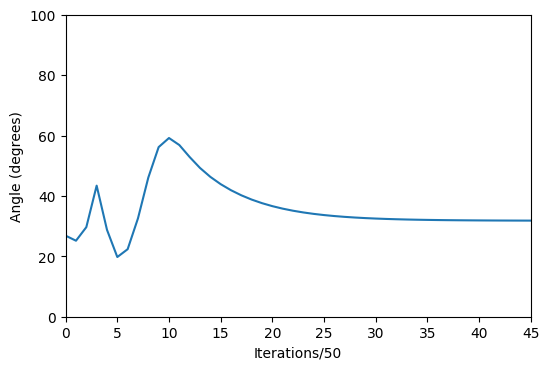

In [8]:
plt.plot(range(len(angles)), angles)
plt.xlabel('Iterations/50')
plt.ylabel('Angle (degrees)')
plt.xlim([0, range(len(angles))[-1]])
plt.ylim([0, 100])

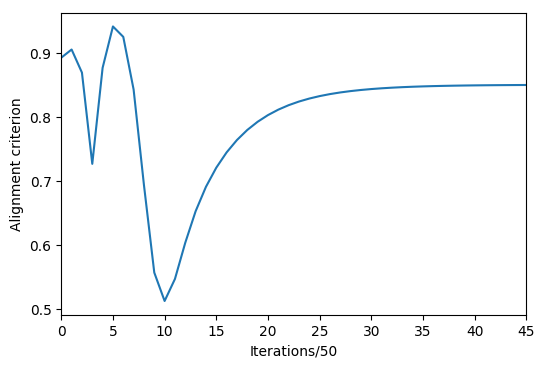

In [9]:
plt.plot(range(len(Lk)), Lk)
plt.xlim([0, range(len(Lk))[-1]])
plt.xlabel('Iterations/50')
plt.ylabel('Alignment criterion')